# Tourette Syndrome CBIT - Aperiodic Analysis

In [1]:
!pip install mne specparam scipy matplotlib pandas seaborn pingouin

In [29]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from specparam import SpectralModel
from specparam import SpectralGroupModel
from scipy import stats
import pingouin as pg
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

print('Imports OK')

Imports OK


In [60]:
# === EDIT THESE FILE PATHS TO MATCH YOUR EXACT FILES ===
DATA_DIR = Path('/Users/elizabethkaplan/Desktop/Greene/TReC_EI_Balance')
OUTPUT_DIR = Path('/Users/elizabethkaplan/Desktop/Greene/TReC_EI_Balance')
#OUTPUT_DIR.mkdir(exist_ok=True)

FILES = {
    '803': {
        'pre': DATA_DIR / 'TReC_803_preEEG_EI.set',
        'post': DATA_DIR / 'TReC_803_postEEG_EI.set'
    },
    '12237': {
        'pre': DATA_DIR / 'TReC_12237_preEEG_EI.set',
        'post': DATA_DIR / 'TRec_12237_postEEG_EI.set'
    }
}

# Check files exist
print('Checking files...\n')
matched = []
for pid, paths in FILES.items():
    pre_ok = paths['pre'].exists()
    post_ok = paths['post'].exists()
    print(f'{pid}: PRE={"OK" if pre_ok else "MISSING"} POST={"OK" if post_ok else "MISSING"}')
    if pre_ok and post_ok:
        matched.append(pid)

print(f'\nMatched: {matched}')

if not matched:
    print('\nFILES NOT FOUND! Available files:')
    for f in DATA_DIR.glob('*.set') if DATA_DIR.exists() else Path('.').glob('*.set'):
        print(f'  {f.name}')

Checking files...

803: PRE=OK POST=OK
12237: PRE=OK POST=OK

Matched: ['803', '12237']


In [61]:
# LOAD
print('Loading...\n')
datasets = {'pre': {}, 'post': {}}

for pid in matched:
    for cond in ['pre', 'post']:
        fpath = FILES[pid][cond]
        print(f'{pid} {cond.upper()}: {fpath.name}')
        raw = mne.io.read_raw_eeglab(str(fpath), preload=True, verbose=False)
        datasets[cond][pid] = raw
        print(f'  -> {len(raw.ch_names)} ch, {raw.times[-1]:.1f}s')

print(f'\nLoaded {len(matched)} participants')

Loading...

803 PRE: TReC_803_preEEG_EI.set
  -> 54 ch, 810.9s
803 POST: TReC_803_postEEG_EI.set
  -> 59 ch, 347.5s
12237 PRE: TReC_12237_preEEG_EI.set
  -> 64 ch, 613.4s
12237 POST: TRec_12237_postEEG_EI.set
  -> 61 ch, 745.6s

Loaded 2 participants


In [67]:
# INSERT BLOCK TIMESTAMPS 

def segment_by_blocks(raw, block_marker='Block'):
    """
    Segment raw data into rest and suppress blocks.
    
    Assumes alternating onset/offset pattern:
      - Even indices (0, 2, 4...) = block onset (rest starts)
      - Odd indices (1, 3, 5...) = block offset (rest ends)
      - Suppress block runs between offset and next onset
    
    Parameters
    ----------
    raw : mne.io.Raw
        Raw EEG data with annotations
    block_marker : str
        Annotation description to look for
    
    Returns
    -------
    dict with keys:
        'rest': mne.io.Raw concatenated rest segments
        'suppress': mne.io.Raw concatenated suppress segments  
        'rest_times': list of (start, end) tuples
        'suppress_times': list of (start, end) tuples
    """
    # Extract block marker times
    block_times = sorted([
        onset for desc, onset in 
        zip(raw.annotations.description, raw.annotations.onset)
        if block_marker.lower() in desc.lower()
    ])
    
    if len(block_times) < 2:
        print(f'Warning: Found {len(block_times)} block markers, need at least 2')
        return None
    
    # Parse into segments
    rest_times = []
    suppress_times = []
    
    for i in range(0, len(block_times) - 1, 2):
        onset = block_times[i]
        offset = block_times[i + 1]
        rest_times.append((onset, offset))
        
        if i + 2 < len(block_times):
            suppress_times.append((offset, block_times[i + 2]))
    
    # Extract segments
    def concat_segments(raw, times):
        raws = []
        for tmin, tmax in times:
            tmax = min(tmax, raw.times[-1])
            if tmin < tmax:
                raws.append(raw.copy().crop(tmin=tmin, tmax=tmax))
        if not raws:
            return None
        return mne.concatenate_raws(raws) if len(raws) > 1 else raws[0]
    
    return {
        'rest': concat_segments(raw, rest_times),
        'suppress': concat_segments(raw, suppress_times),
        'rest_times': rest_times,
        'suppress_times': suppress_times
    }

# actually add in block markers
pre_12237 = datasets['pre']['12237']
post_12237 = datasets['post']['12237']

pre_result_12237 = segment_by_blocks(pre_12237, 'Block')
post_result_12237 = segment_by_blocks(post_12237, 'Block')

In [65]:
## functions --- IN PROGRESS 

def compute_condition_psd(result_dict, fs):
    """
    Compute PSD for each condition (e.g., 'rest', 'suppress')
    in a segmented dictionary returned by segment_by_blocks().

    Parameters
    ----------
    result_dict : dict
        Dictionary containing raw objects per condition:
        e.g., {'rest': Raw, 'suppress': Raw, ...}

    fs : float
        Sampling frequency (raw.info['sfreq'])

    Returns
    -------
    psd_results : dict
        Dictionary with structure:
        {
            cond: {
                'freqs': array (n_freqs,),
                'psd': array (n_channels, n_freqs),
                'ch_names': list of str
            }, ...
        }
    """
    
    PSD_SETTINGS = {
        'method': 'welch',
        'window': 'hamm',
        'average': 'median',
        'fmin': 0.1,
        'fmax': 50.,
        'n_fft': 1024,
        'n_overlap': int(fs * 0.5),
        'n_per_seg': int(fs),
    }

    psd_results = {}

    for cond in ['rest', 'suppress']:
        if cond not in result_dict or result_dict[cond] is None:
            print(f"Condition '{cond}' missing — skipping.")
            continue

        raw_block = result_dict[cond]

        # Segment into rest / suppress for THIS raw only 
        segments = segment_by_blocks(raw, block_marker='Block')
        if segments is None:
            continue

        # Compute PSD for this block
        block_psd = raw_block.compute_psd(**PSD_SETTINGS)

        freqs = block_psd.freqs
        psd_data = block_psd.get_data()      # (n_channels, n_freqs)
        ch_names = raw_block.ch_names

        # Store results
        psd_results[cond] = {
            'freqs': freqs,
            'psd': psd_data,
            'ch_names': ch_names
        }

    return psd_results

import os
import numpy as np
from specparam import SpectralGroupModel

def fit_aperiodic_from_psd(
    psd_results,
    output_root,
    pid,
    session_label,
    freq_range=(1, 40),
    conditions=('rest', 'suppress'),
):
    """
    Fit SpecParam aperiodic exponents per channel & condition from PSDs,
    save models, and return global (channel-averaged) exponents.

    Returns
    -------
    dict or None
        {
            'aperiodic_summary': {cond: {ch: exponent}},
            'rest_global': float,
            'supp_global': float,
            'post_global': float,
            'subject_model_dir': str,
        }
        or None if no valid channels/conditions were fit.
    """

    # create output dir for this subject + session
    subject_model_dir = os.path.join(output_root, f"{pid}_{session_label}")
    os.makedirs(subject_model_dir, exist_ok=True)

    # dict to hold per-channel exponents
    aperiodic_summary = {cond: {} for cond in conditions}
    any_fitted = False  # track if anything succeeded

    for cond in conditions:
        if cond not in psd_results:
            continue

        freqs = psd_results[cond]['freqs']
        psd_data = psd_results[cond]['psd']      # (n_channels, n_freqs)
        ch_names = psd_results[cond]['ch_names']

        for chan_idx, ch_name in enumerate(ch_names):
            this_psd = psd_data[chan_idx, :]           # (n_freqs,)
            this_psd_group = this_psd[np.newaxis, :]   # (1, n_freqs)
            this_psd_group = this_psd_group.astype(float)

            # Replace NaNs / Infs with 0
            this_psd_group = np.nan_to_num(
                this_psd_group,
                nan=0.0,
                posinf=0.0,
                neginf=0.0
            )

            # Ensure strictly positive values (for log)
            positive_mask = this_psd_group > 0
            if not np.any(positive_mask):
                aperiodic_summary[cond][ch_name] = np.nan
                continue

            min_pos = this_psd_group[positive_mask].min()
            eps = min_pos * 1e-3 if min_pos > 0 else 1e-12
            this_psd_group[~positive_mask] = eps

            sg = SpectralGroupModel(
                peak_width_limits=[1, 12],
                max_n_peaks=5,
                min_peak_height=0,
                peak_threshold=2,
                aperiodic_mode='fixed',
            )

            try:
                sg.fit(freqs, this_psd_group, freq_range)
                exps = sg.get_params('aperiodic', 'exponent')
                ch_exp = np.nanmean(exps)
                any_fitted = True
            except Exception:
                ch_exp = np.nan

            aperiodic_summary[cond][ch_name] = ch_exp

            out_fname = os.path.join(
                subject_model_dir,
                f"{cond}_{ch_name}_specparam_results"
            )
            sg.save(out_fname, save_results=True, save_settings=True, save_data=True)

    # If nothing fit successfully, bail out
    if not any_fitted:
        ret


In [66]:
# CALCULATE PSD AND FIT SPECPARAM ON ALL SUBJS -- IN PROGRESS 

all_exponents = []  # rows for the output dataframe

for pid in matched:
    print(f'\n===== Subject {pid} =====')

    for sess in ['pre', 'post']:

        raw = datasets[sess].get(pid, None)
        raw
        if raw is None:
            continue  

        segments = segment_by_blocks(raw, block_marker='Block')
        if segments is None:
            continue

        # Compute PSD per condition 
        fs = raw.info['sfreq']
        psd_results = compute_condition_psd(segments, fs)
        if len(psd_results) == 0:
            continue

        # Fit specparam
        fit_out = fit_aperiodic_from_psd(
            psd_results=psd_results,
            output_root=OUTPUT_DIR,
            pid=pid,
            session_label=sess,
            freq_range=(1, 40),
            conditions=('rest', 'suppress'),
        )

        # calculate average values
        rest_global  = fit_out['rest_global']
        supp_global  = fit_out['supp_global']
        post_global  = fit_out['post_global']

        all_exponents.append({
            'pid': pid,
            'session': sess,
            'rest_global': rest_global,
            'suppress_global': supp_global,
            'post_global': post_global,
        })

# save output
exponents_df = pd.DataFrame(all_exponents)
print("\nDone! Extracted aperiodic exponents for all subjects.")

summary_path = os.path.join(OUTPUT_DIR, 'aperiodic_exponents_summary.csv')
exponents_df.to_csv(summary_path, index=False)


===== Subject 803 =====
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spec

TypeError: 'NoneType' object is not subscriptable

In [81]:
## PSD - per condition x per channel 

#file names:
#pre_result_12237
#post_result_12237

# result dict from your segment_by_blocks
post_result_12237 = segment_by_blocks(post_12237, 'Block')

# use the original Raw to get fs
fs = post_12237.info['sfreq']

PSD_SETTINGS = {
    'method': 'welch',
    'window': 'hamm',
    'average': 'median',
    'fmin': 0.1,
    'fmax': 50.,
    'n_fft': 1024,
    'n_overlap': int(fs * 0.5),
    'n_per_seg': int(fs),
}

psd_results = {}

for cond in ['rest', 'suppress']:
    raw_block = post_result_12237[cond]      # <- use the dict of segments

    if raw_block is None:
        continue  # e.g. no suppress data

    # compute psd for this block
    block_psd = raw_block.compute_psd(**PSD_SETTINGS)

    freqs = block_psd.freqs                # (n_freqs,)
    psd_data = block_psd.get_data()        # (n_channels, n_freqs)
    ch_names = raw_block.ch_names

    # save psd results in dict
    psd_results[cond] = {
        'freqs': freqs,
        'psd': psd_data,
        'ch_names': ch_names,
    }

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


In [82]:
## FIT SPECPARAM

#functionize this: #can change this -- this most common range? 

freq_range = [1, 40] 

#create output dir 
subject_model_dir = os.path.join(OUTPUT_DIR, f"{pid}_{cond}") 
os.makedirs(subject_model_dir, exist_ok=True) 

#dict to hold results 
aperiodic_summary = { 'rest': {}, 'suppress': {} } 

for cond in ['rest', 'suppress']: 
    freqs = psd_results[cond]['freqs'] 
    psd_data = psd_results[cond]['psd'] 
    ch_names = psd_results[cond]['ch_names'] 
    
    for chan_idx, ch_name in enumerate(ch_names): 
        this_psd = psd_data[chan_idx, :] 
        this_psd_group = this_psd[np.newaxis, :] 
        sg = SpectralGroupModel( peak_width_limits=[1, 12], 
                                 max_n_peaks=5, 
                                 min_peak_height=0, 
                                 peak_threshold=2, 
                                 aperiodic_mode='fixed', ) 
        sg.fit(freqs, this_psd_group, freq_range) 
        
        #store exponent 
        exps = sg.get_params('aperiodic', 'exponent') 
        #average 
        ch_exp = np.nanmean(exps) 
        #store 
        aperiodic_summary[cond][ch_name] = ch_exp 
        out_fname = os.path.join( subject_model_dir, f"{cond}_{ch_name}_specparam_results" ) 
        sg.save(out_fname, save_results=True, save_settings=True, save_data=True) 
        #calculate avg across conditions 
        rest_exponents = list(aperiodic_summary['rest'].values()) 
        supp_exponents = list(aperiodic_summary['suppress'].values()) 
        rest_global = np.nanmean(rest_exponents) 
        supp_global = np.nanmean(supp_exponents) 
        post_global = np.nanmean([rest_global, supp_global]) 
        
print("Global aperiodic exponent:") 
print(" Rest :", rest_global) 
print(" Suppress:", supp_global) 
print("post_global:", post_global)

Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting model across 1 power spectra.
Fitting mode

In [83]:
# === PRE values ===
pre_rest_global     = 1.2142476273680536
pre_suppress_global = 1.2212120475012067
pre_post_global     = 1.2177298374346301

# === POST values ===
post_rest_global     = 1.28669814932611
post_suppress_global = 1.295194671016989
post_post_global     = 1.2909464101715495

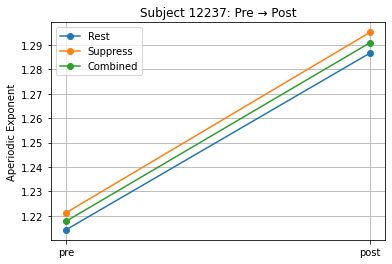

In [84]:
sessions = ['pre', 'post']

plt.figure(figsize=(6,4))
plt.plot(sessions, [pre_rest_global, post_rest_global], marker='o', label='Rest')
plt.plot(sessions, [pre_suppress_global, post_suppress_global], marker='o', label='Suppress')
plt.plot(sessions, [pre_post_global, post_post_global], marker='o', label='Combined')

plt.ylabel('Aperiodic Exponent')
plt.title('Subject 12237: Pre → Post')
plt.grid(True)
plt.legend()
plt.show()


In [87]:
delta_rest = post_rest_global - pre_rest_global
delta_suppress = post_suppress_global - pre_suppress_global
delta_global = post_post_global - pre_post_global

print(delta_rest)
print(delta_suppress)
print(delta_global)

0.07245052195805646
0.07398262351578233
0.0732165727369194


In [40]:
# COMPUTE AVERAGED PSD -- ACROSS CONDITIONS
print('Computing PSD...')
psds = {'pre': {}, 'post': {}}
psds_avg = {'pre': {}, 'post': {}}
freqs = None

for pid in matched:
    for cond in ['pre', 'post']:
        raw = datasets[cond][pid]
        spectrum = raw.compute_psd(method='welch', fmin=1, fmax=40, n_fft=2048, verbose=False)
        psds[cond][pid] = spectrum.get_data()
        psds_avg[cond][pid] = spectrum.get_data().mean(axis=0)
        if freqs is None:
            freqs = spectrum.freqs
    print(f'  {pid} done')

print('Done')

Computing PSD...
  803 done
  12237 done
Done


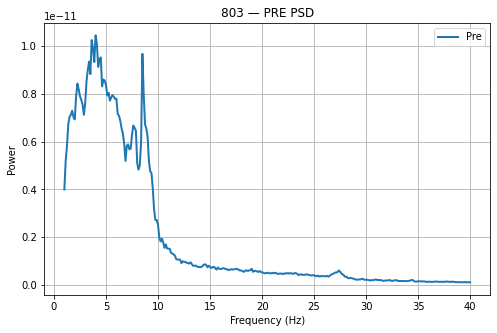

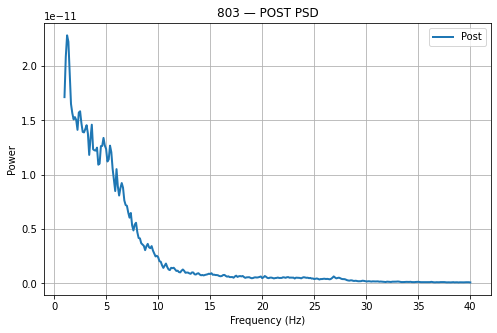

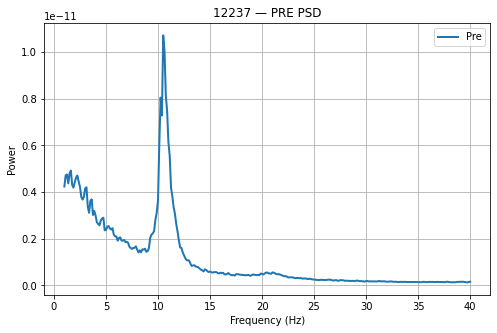

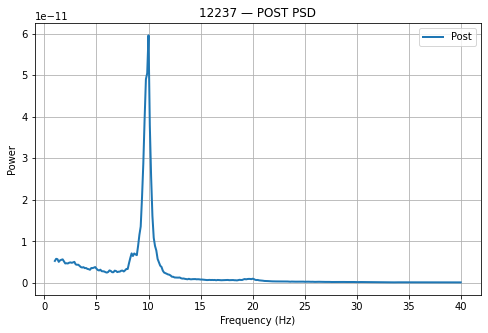

In [42]:
for pid in matched:

    # PRE plot 
    plt.figure(figsize=(8,5))
    plt.plot(freqs, psds_avg['pre'][pid], label='Pre', linewidth=2)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title(f"{pid} — PRE PSD")
    plt.grid(True)
    plt.legend()
    plt.show()

    # POST plot
    plt.figure(figsize=(8,5))
    plt.plot(freqs, psds_avg['post'][pid], label='Post', linewidth=2)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title(f"{pid} — POST PSD")
    plt.grid(True)
    plt.legend()
    plt.show()

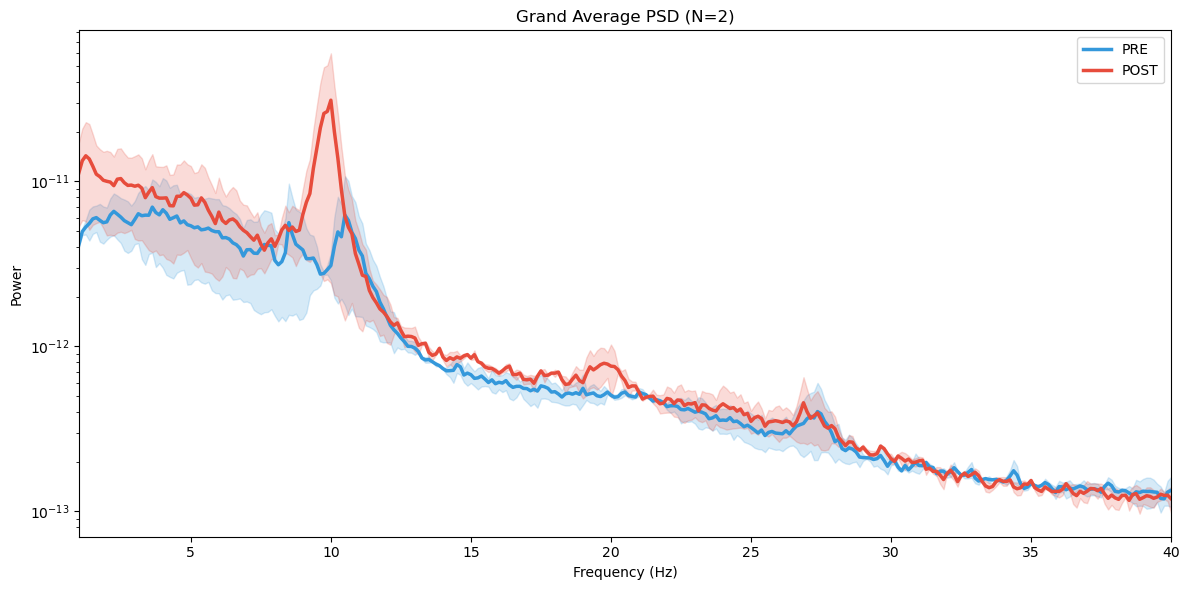

In [6]:
# GRAND AVERAGE PSD

fig, ax = plt.subplots(figsize=(12, 6))

for cond, color in [('pre', '#3498db'), ('post', '#e74c3c')]:
    arr = np.aray([psds_avg[cond][p] for p in matched])
    m = arr.mean(axis=0)
    s = stats.sem(arr, axis=0)
    ax.semilogy(freqs, m, color=color, lw=2.5, label=cond.upper())
    ax.fill_between(freqs, m-s, m+s, color=color, alpha=0.2)

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')
ax.set_title(f'Grand Average PSD (N={len(matched)})')
ax.legend()
ax.set_xlim([1, 40])
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'grand_avg_psd.png', dpi=300)
plt.show()

In [7]:
# EXTRACT APERIODIC EXPONENTS
print('Extracting exponents...\n')

exponents = {'pre': {}, 'post': {}}
offsets = {'pre': {}, 'post': {}}
specparam_models = {'pre': {}, 'post': {}}

for pid in matched:
    print(f'{pid}:')
    for cond in ['pre', 'post']:
        sp = SpectralModel(peak_width_limits=[1,8], max_n_peaks=6, min_peak_height=0.1, aperiodic_mode='fixed')
        sp.fit(freqs, psds_avg[cond][pid], [1, 40])
        
        ap = sp.get_params('aperiodic')
        exponents[cond][pid] = ap[1]
        offsets[cond][pid] = ap[0]
        specparam_models[cond][pid] = sp
        
        print(f'  {cond.upper()}: offset={ap[0]:.4f}, exp={ap[1]:.4f}')

print('\nDone')

Extracting exponents...

803:
  PRE: offset=-10.6894, exp=1.3485
  POST: offset=-10.2623, exp=1.6583
12237:
  PRE: offset=-10.9578, exp=1.1815
  POST: offset=-10.8343, exp=1.2445

Done


In [8]:
# MODEL FIT QUALITY CHECK

print('MODEL FIT METRICS')
print('=' * 60)

for pid in sorted(matched):
    print(f'\nParticipant {pid}:')
    for cond in ['pre', 'post']:
        sp = specparam_models[cond][pid]
        r2 = sp.results.metrics.results['gof_rsquared']
        mae = sp.results.metrics.results['error_mae']
        print(f'  {cond.upper()}: R² = {r2:.4f}, MAE = {mae:.4f}')

print('\n' + '=' * 60)
print('Threshold: R² > 0.90 = good fit')

MODEL FIT METRICS

Participant 12237:
  PRE: R² = 0.9897, MAE = 0.0352
  POST: R² = 0.9898, MAE = 0.0444

Participant 803:
  PRE: R² = 0.9686, MAE = 0.0835
  POST: R² = 0.9885, MAE = 0.0499

Threshold: R² > 0.90 = good fit


In [9]:
# RESULTS TABLE
results = []
for pid in matched:
    pre = exponents['pre'][pid]
    post = exponents['post'][pid]
    results.append({'ID': pid, 'PRE': pre, 'POST': post, 'Change': post-pre, '%Change': (post-pre)/abs(pre)*100})

df = pd.DataFrame(results)
print('RESULTS')
print('='*60)
print(df.to_string(index=False))

RESULTS
   ID      PRE     POST   Change   %Change
  803 1.348514 1.658303 0.309789 22.972582
12237 1.181468 1.244515 0.063047  5.336331


In [10]:
# STATISTICS
pre_vals = df['PRE'].values
post_vals = df['POST'].values
diff = post_vals - pre_vals
n = len(matched)

print('STATISTICS')
print('='*60)
print(f'PRE:  {pre_vals.mean():.4f} +/- {pre_vals.std(ddof=1):.4f}')
print(f'POST: {post_vals.mean():.4f} +/- {post_vals.std(ddof=1):.4f}')
print(f'Delta: {diff.mean():.4f} +/- {diff.std(ddof=1):.4f}')

if n > 1 and diff.std() > 0:
    d = diff.mean() / diff.std(ddof=1)
    print(f'\nCohen d: {d:.4f}')
    
    t, p = stats.ttest_rel(pre_vals, post_vals)
    print(f't-test: t={t:.4f}, p={p:.4f}')
    
    try:
        w, pw = stats.wilcoxon(pre_vals, post_vals)
        print(f'Wilcoxon: W={w}, p={pw:.4f}')
    except: pass
    
    # Permutation
    np.random.seed(42)
    perms = [np.mean(np.random.choice([-1,1], n) * diff) for _ in range(10000)]
    p_perm = np.mean(np.abs(perms) >= np.abs(diff.mean()))
    print(f'Permutation: p={p_perm:.4f}')
    
    try:
        bf = pg.ttest(post_vals, pre_vals, paired=True)['BF10'].values[0]
        print(f'Bayes: BF10={bf:.4f}')
    except: pass

STATISTICS
PRE:  1.2650 +/- 0.1181
POST: 1.4514 +/- 0.2926
Delta: 0.1864 +/- 0.1745

Cohen d: 1.0685
t-test: t=-1.5110, p=0.3722
Wilcoxon: W=0.0, p=0.5000
Permutation: p=0.4950


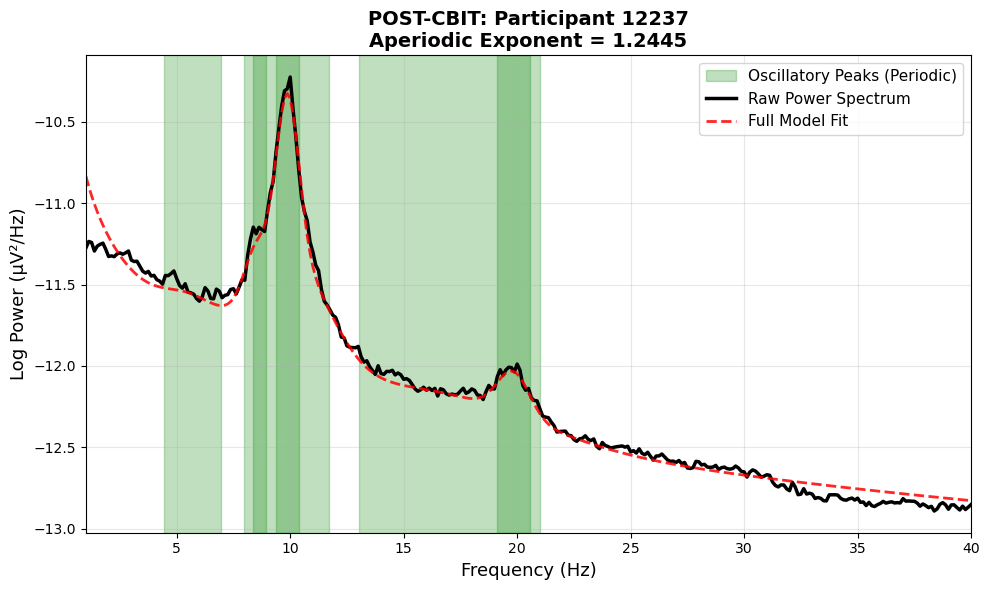

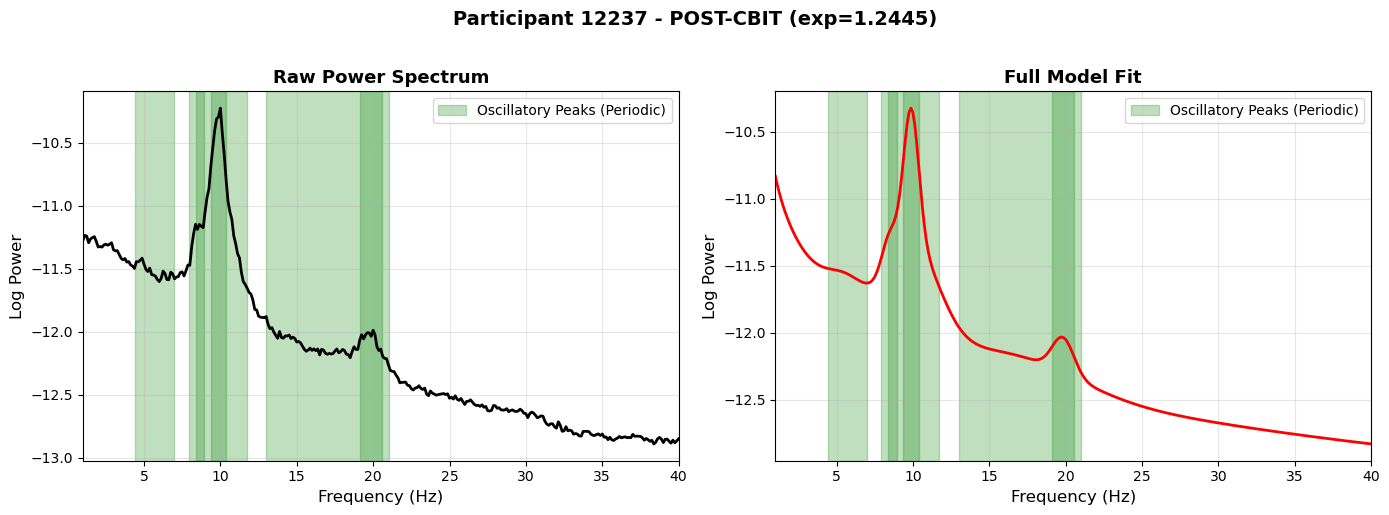

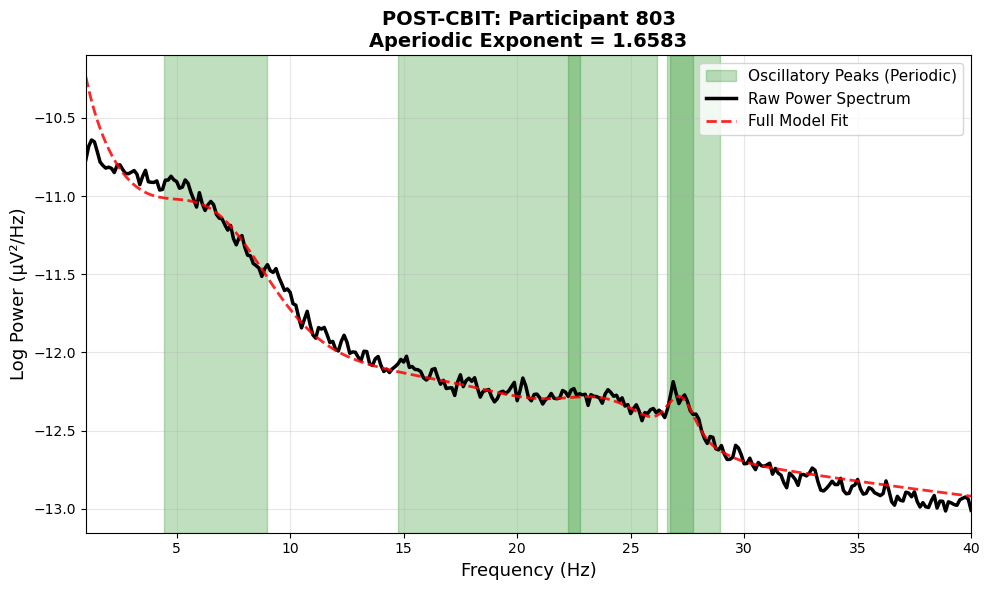

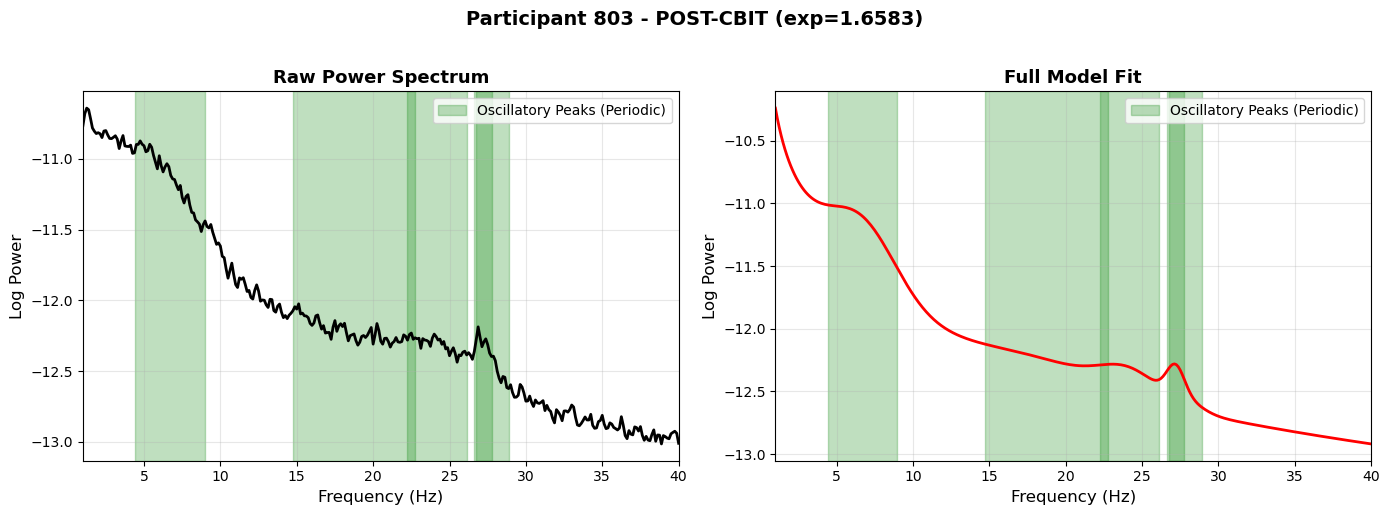

In [11]:
# POST-CBIT PSD PLOTS
# Raw PSD + Full Model Fit (NO aperiodic line), green peaks labeled

for pid in sorted(matched):
    sp = specparam_models['post'][pid]
    
    # specparam 2.0.0rc5 API
    freqs_fit = sp.data.freqs
    psd = sp.data.power_spectrum
    full_fit = sp.results.model.modeled_spectrum
    
    # Get peaks for shading
    peaks = sp.get_params('peak')
    if peaks is None or len(peaks) == 0:
        peaks = []
    else:
        peaks = np.atleast_2d(peaks)
    
    # === FIGURE 1: Overlay ===
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Green shading for oscillatory peaks
    peak_added = False
    for pk in peaks:
        cf, pw, bw = pk[0], pk[1], pk[2]
        ax.axvspan(cf - bw/2, cf + bw/2, color='green', alpha=0.25,
                   label='Oscillatory Peaks (Periodic)' if not peak_added else None)
        peak_added = True
    
    # Raw PSD (black)
    ax.plot(freqs_fit, psd, 'k', lw=2.5, label='Raw Power Spectrum')
    
    # Full model fit (red dashed)
    ax.plot(freqs_fit, full_fit, 'r--', lw=2, alpha=0.85, label='Full Model Fit')
    
    ax.set_xlabel('Frequency (Hz)', fontsize=13)
    ax.set_ylabel('Log Power (μV²/Hz)', fontsize=13)
    ax.set_title(f'POST-CBIT: Participant {pid}\n'
                 f'Aperiodic Exponent = {exponents["post"][pid]:.4f}',
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=11, loc='upper right')
    ax.set_xlim([1, 40])
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'post_psd_overlay_{pid}.png', dpi=300)
    plt.show()
    
    # === FIGURE 2: Side-by-Side ===
    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))
    
    for i, (ax2, data, title, col) in enumerate([
        (axes2[0], psd, 'Raw Power Spectrum', 'k'),
        (axes2[1], full_fit, 'Full Model Fit', 'r')
    ]):
        peak_added = False
        for pk in peaks:
            ax2.axvspan(pk[0] - pk[2]/2, pk[0] + pk[2]/2, 
                       color='green', alpha=0.25,
                       label='Oscillatory Peaks (Periodic)' if not peak_added else None)
            peak_added = True
        
        ax2.plot(freqs_fit, data, col, lw=2)
        ax2.set_xlabel('Frequency (Hz)', fontsize=12)
        ax2.set_ylabel('Log Power', fontsize=12)
        ax2.set_title(title, fontsize=13, fontweight='bold')
        ax2.legend(fontsize=10, loc='upper right')
        ax2.set_xlim([1, 40])
        ax2.grid(True, alpha=0.3)
    
    fig2.suptitle(f'Participant {pid} - POST-CBIT (exp={exponents["post"][pid]:.4f})',
                  fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'post_psd_sidebyside_{pid}.png', dpi=300)
    plt.show()

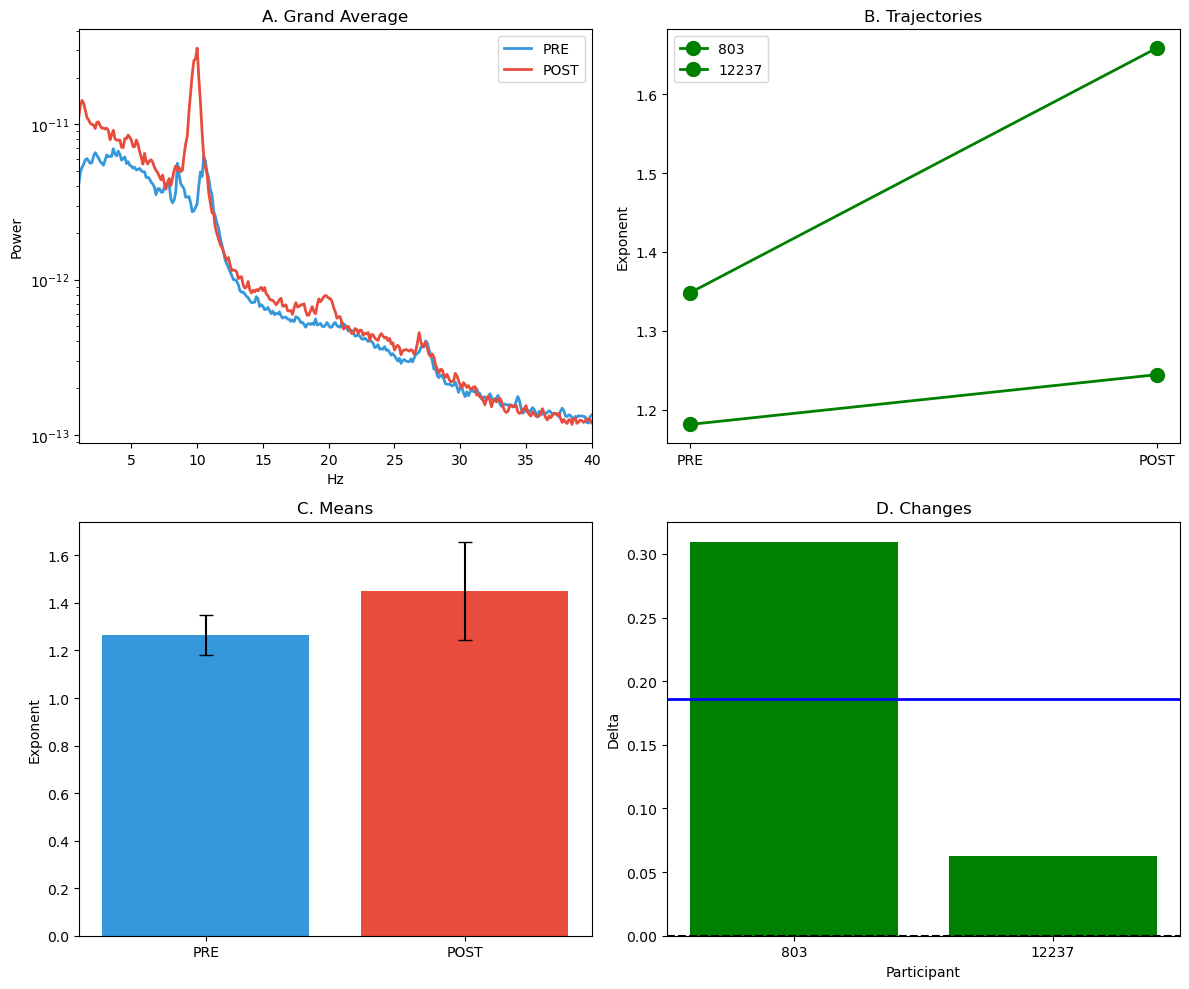

In [12]:
# FIGURE
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# A: PSD
ax = axes[0,0]
for cond, col in [('pre', '#3498db'), ('post', '#e74c3c')]:
    m = np.mean([psds_avg[cond][p] for p in matched], axis=0)
    ax.semilogy(freqs, m, color=col, lw=2, label=cond.upper())
ax.set_xlabel('Hz'); ax.set_ylabel('Power')
ax.set_title('A. Grand Average'); ax.legend(); ax.set_xlim([1,40])

# B: Trajectories
ax = axes[0,1]
for i, pid in enumerate(matched):
    c = 'green' if post_vals[i] > pre_vals[i] else 'red'
    ax.plot([0,1], [pre_vals[i], post_vals[i]], 'o-', color=c, ms=10, lw=2, label=pid)
ax.set_xticks([0,1]); ax.set_xticklabels(['PRE','POST'])
ax.set_ylabel('Exponent'); ax.set_title('B. Trajectories'); ax.legend()

# C: Means
ax = axes[1,0]
ax.bar([0,1], [pre_vals.mean(), post_vals.mean()], yerr=[stats.sem(pre_vals), stats.sem(post_vals)],
       capsize=5, color=['#3498db','#e74c3c'])
ax.set_xticks([0,1]); ax.set_xticklabels(['PRE','POST'])
ax.set_ylabel('Exponent'); ax.set_title('C. Means')

# D: Change
ax = axes[1,1]
colors = ['green' if d>0 else 'red' for d in diff]
ax.bar(range(n), diff, color=colors)
ax.axhline(0, color='k', ls='--')
ax.axhline(diff.mean(), color='blue', lw=2)
ax.set_xticks(range(n)); ax.set_xticklabels(matched)
ax.set_xlabel('Participant'); ax.set_ylabel('Delta'); ax.set_title('D. Changes')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figure.png', dpi=300)
plt.savefig(OUTPUT_DIR / 'figure.pdf')
plt.show()

In [13]:
# BAND POWER
BANDS = {'theta': (4,8), 'alpha': (8,13), 'beta': (13,30), 'gamma': (30,40)}

band_power = {'pre': {}, 'post': {}}
for pid in matched:
    for cond in ['pre', 'post']:
        psd = psds_avg[cond][pid]
        band_power[cond][pid] = {}
        for band, (lo, hi) in BANDS.items():
            idx = (freqs >= lo) & (freqs <= hi)
            band_power[cond][pid][band] = np.trapz(psd[idx], freqs[idx])

rows = []
for pid in matched:
    for cond in ['pre', 'post']:
        row = {'ID': pid, 'Cond': cond}
        row.update(band_power[cond][pid])
        rows.append(row)
print(pd.DataFrame(rows).to_string(index=False))

   ID Cond        theta        alpha         beta        gamma
  803  pre 2.963106e-11 1.450023e-11 8.833889e-12 1.508557e-12
  803 post 3.739542e-11 1.082358e-11 9.458138e-12 1.396777e-12
12237  pre 8.668283e-12 1.667063e-11 6.960546e-12 1.556723e-12
12237 post 1.213971e-11 5.992479e-11 9.164497e-12 1.590350e-12


In [14]:
# ROI ANALYSIS
ROIS = {'frontal': ['Fp1','Fp2','F3','F4','Fz'], 'central': ['C3','C4','Cz'], 
        'parietal': ['P3','P4','Pz'], 'occipital': ['O1','O2','Oz']}

roi_exp = {'pre': {}, 'post': {}}
for pid in matched:
    for cond in ['pre', 'post']:
        chs = datasets[cond][pid].ch_names
        psd_data = psds[cond][pid]
        roi_exp[cond][pid] = {}
        for roi, roi_chs in ROIS.items():
            idx = [i for i, ch in enumerate(chs) if ch in roi_chs]
            if idx:
                roi_psd = psd_data[idx].mean(axis=0)
                sp = SpectralModel(peak_width_limits=[1,8], max_n_peaks=6, min_peak_height=0.1, verbose=False)
                sp.fit(freqs, roi_psd, [1,40])
                roi_exp[cond][pid][roi] = sp.get_params('aperiodic')[1]
            else:
                roi_exp[cond][pid][roi] = np.nan

rows = []
for pid in matched:
    for cond in ['pre', 'post']:
        row = {'ID': pid, 'Cond': cond}
        row.update(roi_exp[cond][pid])
        rows.append(row)
print(pd.DataFrame(rows).to_string(index=False))

   ID Cond  frontal  central  parietal  occipital
  803  pre 1.212938 1.410257  1.518696   1.403836
  803 post 1.705346 1.592860  1.548793   1.581262
12237  pre 0.938099 1.309665  1.392992   1.543193
12237 post 1.194440 1.362994  1.416429   1.378561


In [15]:
# SAVE
df.to_csv(OUTPUT_DIR / 'exponents.csv', index=False)
print(f'Saved to {OUTPUT_DIR}')

Saved to TS_Results


In [16]:
# CHECK EVENT MARKERS
print('Event markers:')
for pid in matched:
    print(f'\n{pid}:')
    for cond in ['pre', 'post']:
        raw = datasets[cond][pid]
        if len(raw.annotations) > 0:
            print(f'  {cond}: {set(raw.annotations.description)}')
        else:
            print(f'  {cond}: None')

Event markers:

803:
  pre: {np.str_('block_offset'), np.str_('0, Impedance'), np.str_('block_onset'), np.str_('boundary')}
  post: {np.str_('block_offset'), np.str_('block_onset'), np.str_('boundary')}

12237:
  pre: {np.str_('block_offset'), np.str_('block_onset'), np.str_('0, Impedance'), np.str_('boundary')}
  post: {np.str_('boundary')}


In [63]:
# EXPLORE EVENT MARKERS IN DETAIL

for pid in matched:
    print(f"\n{'='*60}")
    print(f"PARTICIPANT {pid}")
    print('='*60)
    
    for cond in ['pre', 'post']:
        raw = datasets[cond][pid]
        annot = raw.annotations
        
        print(f"\n--- {cond.upper()} ---")
        print(f"Recording duration: {raw.times[-1]:.1f} seconds")
        print(f"Total annotations: {len(annot)}")
        
        if len(annot) > 0:
            print(f"\nAll events (onset, duration, description):")
            print("-" * 50)
            
            for i, (onset, dur, desc) in enumerate(zip(annot.onset, annot.duration, annot.description)):
                print(f"  {i+1:3d}. {onset:8.2f}s  |  dur={dur:.2f}s  |  {desc}")
            
            # Count by type
            print(f"\nEvent counts:")
            from collections import Counter
            counts = Counter(annot.description)
            for desc, count in counts.items():
                print(f"  {desc}: {count}")
            
            # Block timing
            block_onsets = [onset for onset, desc in zip(annot.onset, annot.description) if 'block_onset' in str(desc)]
            block_offsets = [onset for onset, desc in zip(annot.onset, annot.description) if 'block_offset' in str(desc)]
            
            if block_onsets and block_offsets:
                print(f"\nBlock structure:")
                for i, (on, off) in enumerate(zip(block_onsets, block_offsets)):
                    print(f"  Block {i+1}: {on:.1f}s - {off:.1f}s (duration: {off-on:.1f}s)")
        else:
            print("  No annotations found")


PARTICIPANT 803

--- PRE ---
Recording duration: 810.9 seconds
Total annotations: 179

All events (onset, duration, description):
--------------------------------------------------
    1.     0.00s  |  dur=0.00s  |  0, Impedance
    2.     0.00s  |  dur=0.13s  |  boundary
    3.     0.01s  |  dur=1.84s  |  boundary
    4.     0.02s  |  dur=1.51s  |  boundary
    5.     1.50s  |  dur=0.28s  |  boundary
    6.     1.51s  |  dur=0.18s  |  boundary
    7.     2.16s  |  dur=0.13s  |  boundary
    8.     2.21s  |  dur=1.53s  |  boundary
    9.     2.63s  |  dur=1.25s  |  boundary
   10.     5.97s  |  dur=0.28s  |  boundary
   11.     9.02s  |  dur=0.95s  |  boundary
   12.    10.20s  |  dur=1.07s  |  boundary
   13.    10.44s  |  dur=0.00s  |  block_onset
   14.    14.97s  |  dur=3.34s  |  boundary
   15.    17.46s  |  dur=0.41s  |  boundary
   16.    19.14s  |  dur=1.24s  |  boundary
   17.    20.27s  |  dur=1.84s  |  boundary
   18.    27.06s  |  dur=2.77s  |  boundary
   19.    39.33s  |

## Interpretation
- **Lower exponent** = More excitation  
- **Higher exponent** = More inhibition  
- **Positive change** = CBIT improved E/I balance